# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 16th of december at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 8 décembre 2021**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [178]:
# Change here using YOUR first and last names
fn1 = "Oumaima"
ln1 = "Bouther"
fn2 = "Ayoub"
ln2 = "Tabaai"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_bouther_oumaima_and_tabaai_ayoub.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import check_grad
import warnings
warnings.filterwarnings('ignore')
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

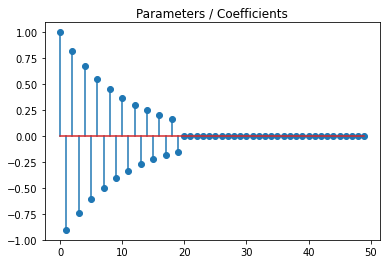

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [112]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [64]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x""" 
    a = np.sign(x)*np.maximum(np.abs(x)-lmbd, 0)
    return a # TODO
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.sum(np.abs(x)) # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    return 1/(1+lmbd)*x # TODO
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd*np.sum(x**2)/2 # TODO

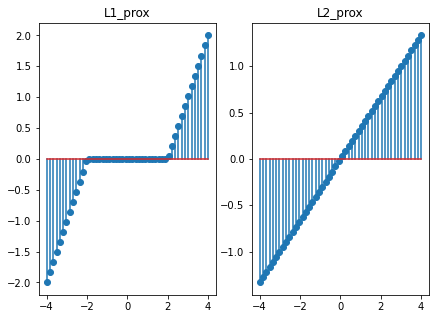

In [65]:
# Plots of L2 and L1 proximity operators
a = np.linspace(-4, 4)
lmbd = 2
fig, ax = plt.subplots(1, 2, figsize = (7, 5))
ax[0].stem(a, prox_L1(a, lmbd))
ax[0].set_title('L1_prox')
ax[1].stem(a, prox_L2(a, lmbd))
ax[1].set_title('L2_prox')
plt.show()

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

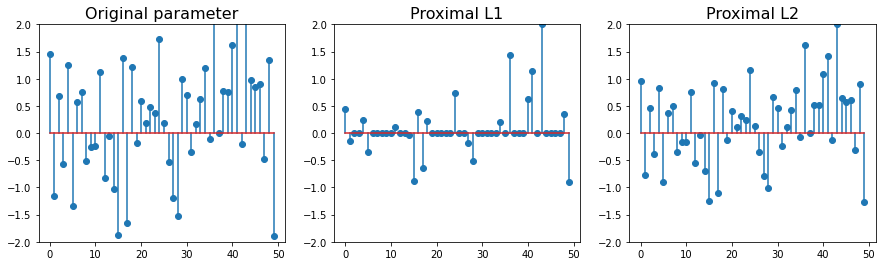

In [66]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])
plt.show()

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

We observe that the lasso proximal operator is shrinking the small values of the coefficients between λ and -λ to 0 and shrinks the other coefficients with a factor of λ. Whereas, the ridge proximal operator is just shrinking the coefficients making them smaller as possible by dividing them by $1+λ$  

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

Let's calculate the gradients \
\
**For the linear regression :**
$$\nabla f = \frac
{1}{n} A^\intercal(Ax - b) 
$$
**For logistic regression :**
$$
\nabla f = -\frac{1}{n} \sum_{i=1}^n \frac{b_ia_i^\intercal x_i}{1 + exp(b_ia_ix )}
$$

In [67]:
def loss_linreg(x):
    """Least-squares loss"""
    # TODO
    n = A.shape[0]
    return 1/n*L2_norm(b-np.dot(A,x),1)

def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    n = A.shape[0]
    return (1./n)*np.dot(A.T,np.dot(A,x)-b)

def loss_logreg(x):
    """Logistic loss"""
    # TODO
    n = A.shape[0]
    return (1./ n)*np.sum(np.log(1+np.exp(-b*(A.dot(x)))))

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    n = A.shape[0]
    return -(1./n)*A.T.dot(b*(1./(1.+np.exp(b * A.dot(x)))))

# TO BE COMPLETED
A, b = simu_linreg(coefs)
d = A.shape[1]
x = np.random.randn(d)
print('least squares loss of the coefs: ',loss_linreg(coefs))
print('checking grad linreg: ',check_grad(loss_linreg, grad_linreg, x))

A, b = simu_logreg(coefs)
d = A.shape[1]
x = np.random.randn(d)
print('logistic loss of the coefs: ',loss_logreg(coefs))
print('checking grad logreg: ',check_grad(loss_logreg, grad_logreg, x))

least squares loss of the coefs:  0.48399109473550156
checking grad linreg:  1.6249158211598718e-06
logistic loss of the coefs:  0.5485438138695402
checking grad logreg:  1.8239518993980549e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [114]:
# TO BE COMPLETED

# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    n = A.shape[0]
    L = 1/n*np.linalg.norm(A.T.dot(A))
    return L

# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    n = A.shape[0]
    L = 1/(4*n)*(np.linalg.norm(A,2)**2)
    return L
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO #### 
        x = prox_R(x - step*grad_f(x),lmbd*step)      
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                            ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [102]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_R(z-step*grad_f(z),lmbd*step)
        t_new = (1+np.sqrt(1+4*t**2))/2
        z = x_new+(t-1)/t_new*(x_new-x)
        t = t_new
        x = x_new
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [97]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [136]:
step = 1/smoothness_const_linreg(A)
w_APGD_l2,obj_APGD_l2,err_APGD_l2 = APGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step = step,lmbd = lmbd,n_iter=1000,x_true=coefs , verbose=False)
print('The APGD minimizer is:',w_APGD_l2)
print('\nThe APGD minimum is:',obj_APGD_l2[-1])

The APGD minimizer is: [ 0.99 -0.9   0.78 -0.65  0.66 -0.63  0.58 -0.41  0.39 -0.46  0.39 -0.3
  0.33 -0.27  0.24 -0.18  0.18 -0.19  0.15 -0.17 -0.   -0.07  0.03  0.01
 -0.01  0.01 -0.03  0.    0.04  0.01  0.02 -0.02 -0.01  0.03  0.   -0.04
 -0.02  0.07 -0.01 -0.05 -0.02 -0.05  0.02  0.02  0.03 -0.01 -0.08  0.07
  0.04  0.02]

The APGD minimum is: 0.5130886618878308


In [134]:
w_APGD_l1,obj_APGD_l1,err_APGD_l1 = APGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1,step = step,lmbd = lmbd,n_iter=1000,x_true=coefs , verbose=False)
w_PGD_l2,obj_PGD_l2,err_PGD_l2 = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step = step,lmbd = lmbd,n_iter=1000,x_true=coefs , verbose=False)
w_PGD_l1,obj_PGD_l1,err_PGD_l1 = PGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1,step = step,lmbd = lmbd,n_iter=1000,x_true=coefs , verbose=False)

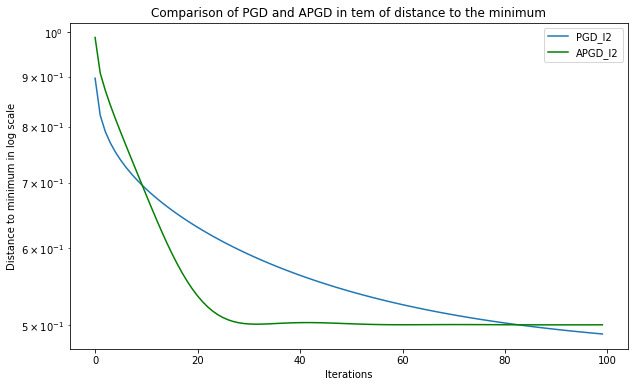

In [176]:
# The distance to the minimum 
plt.figure(figsize=(10,6))
plt.plot(obj_PGD_l2[:100] , label = "PGD_l2")
plt.plot(obj_APGD_l2[:100] , 'g' , label = "APGD_l2")
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Distance to minimum in log scale')
plt.title('Comparison of PGD and APGD in tem of distance to the minimum')
plt.legend(prop={'size':10})
plt.show()

From the plots we can notice that the APGD converges faster to the minimum than the PGD algorithm.Indeed, the minimum is reached within less than 30 iteration, whereas the PGD reached it within 100 iterations.
::

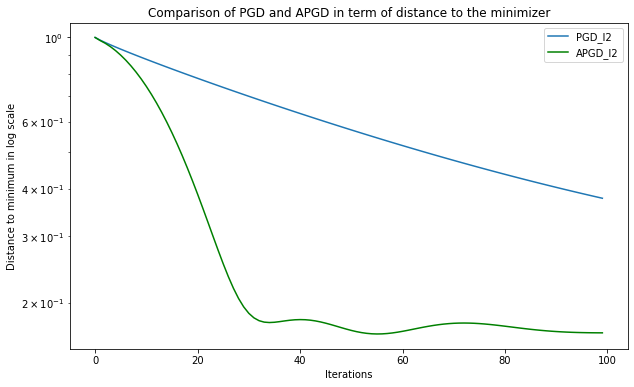

In [179]:
# The distance to the minimizer

plt.figure(figsize=(10,6))
plt.plot(err_PGD_l2[:100] , label = "PGD_l2")
plt.plot(err_APGD_l2[:100] , 'g' , label = "APGD_l2")
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Distance to minimum in log scale')
plt.title('Comparison of PGD and APGD in term of distance to the minimizer')
plt.legend(prop={'size':10})
plt.show()

We notice that the convergence rate of the PGD algorithm is approximatly linear with the number of iterations, while the APGD algorithm is not strictly decreasing but its error is always less than the PGD error.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

**Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.**

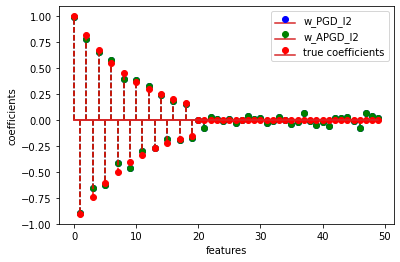

In [165]:
# Comparison of the PGD and the APGD output with the true coefficients

plt.stem(w_PGD_l2,linefmt='b--',  markerfmt='bo',label='w_PGD_l2')
plt.stem(w_APGD_l2,linefmt='g--',  markerfmt='go',label='w_APGD_l2')
plt.stem(coefs,linefmt='r--',  markerfmt='ro',label='true coefficients')
plt.xlabel('features')
plt.ylabel('coefficients')
plt.legend()
plt.show()

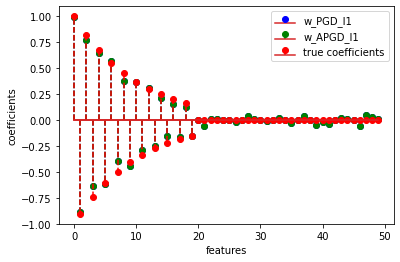

In [166]:
# L1 norm comaprison of the results of the models with the true coefficients

plt.stem(w_PGD_l1,linefmt='b--',  markerfmt='bo',label='w_PGD_l1')
plt.stem(w_APGD_l1,linefmt='g--',  markerfmt='go',label='w_APGD_l1')
plt.stem(coefs,linefmt='r--',  markerfmt='ro',label='true coefficients')
plt.xlabel('features')
plt.ylabel('coefficients')
plt.legend()
plt.show()

Both algorithms APGD and PGD give very close minimum, and they converge to the same minimizer but with a different rate of convergence. Furthermore, the minimizer found for both algorithm is very close to the real features coefficients.

**Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.**

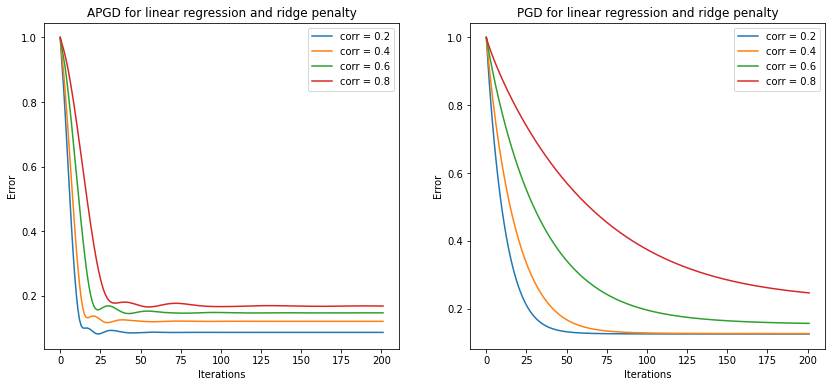

In [175]:
# Influence fo the correlation on the performance of PGD and APGD for L2 norm
corr = [0.2,0.4,0.6,0.8]
corr_legend = ['corr = ' +str(c) for c in corr]

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)

for i in range(len(corr)):
    A,b=simu_linreg(coefs,corr=corr[i])
    w_APGD_l2,obj_APGD_l2,err_APGD_l2 = APGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step = step,lmbd = lmbd,n_iter=200,x_true=coefs , verbose=False)
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.plot(err_APGD_l2,label=corr_legend[i])
    plt.legend()
    plt.title("APGD for linear regression and ridge penalty")

    
plt.subplot(1,2,2)  

for i in range(len(corr)):
    A,b=simu_linreg(coefs,corr=corr[i])
    w_PGD_l2,obj_PGD_l2,err_PGD_l2 = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2,step = step,lmbd = lmbd,n_iter=200,x_true=coefs , verbose=False)
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.plot(err_PGD_l2,label=corr_legend[i])
    plt.legend()
    
    plt.title("PGD for linear regression and ridge penalty")

    
plt.show()

As we remark from the plots that the correlation have a large impact on the linear regression with ridge penalty, and this is more remarquable for the PGD algorithm where we see that when the correlation gets higher, the performance of the PGD gets worse than the APGD performance.

We can conclude that the PGD and APGD are suffering from the highly correlated features, which means that the convergence rate of both algorithms if related to the Lipschitz constant, which itself depends on the the correlation between teh features.


**Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of penalization ( λ ) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when  λ  increases.**

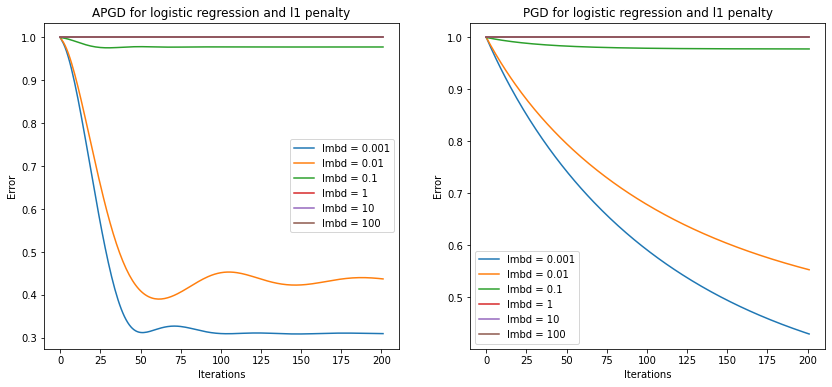

In [180]:
# Influence fo the level of penalization on the performance of PGD and APGD for logistic regression and  L1 norm
lamb = [0.001,0.01,0.1,1,10,100]
lamb_legend = ['lmbd = ' +str(l) for l in lamb]
A,b=simu_logreg(coefs,corr=0.5)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)

for i in range(len(lamb)):
    w_APGD_l1,obj_APGD_l1,err_APGD_l1 = APGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1,step = step,lmbd = lamb[i],n_iter=200,x_true=coefs , verbose=False)
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.plot(err_APGD_l1,label=lamb_legend[i])
    plt.legend()
    plt.title("APGD for logistic regression and l1 penalty")

    
plt.subplot(1,2,2)  

for i in range(len(lamb)):
    w_PGD_l1,obj_PGD_l1,err_PGD_l1 = PGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1,step = step,lmbd = lamb[i],n_iter=200,x_true=coefs , verbose=False)
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.plot(err_PGD_l1,label=lamb_legend[i])
    plt.legend()
    
    plt.title("PGD for logistic regression and l1 penalty")

    
plt.show()

We can see that for higher penalization values, the convergence becomes faster and the error is higher for both algorithms.This could be justified by the fact that for higher values of the penalization the coefficients between λ and -λ would be stack there with a 0 value. Also, when the penalization is larger, most of the coefficients would be 0, so the coefficients are far form the real ones, and then the error is larger.